# Optimización y visualización de máquinas inteligentes en problemas de clasificación

# 0. Inspira

Este jupyter notebook es un complemento de la sección de profundiza del módulo 9 de optimización y visualización de máquinas inteligentes. Por lo que este código debe utilizarse siguiendo en paralelo el contenido de PROFUNDIZA en Canvas.

El objetivo de este recurso es que puedas correr todo el flujo de trabajo para resolver un problema de clasificación, cambiar hiperparámetros, hacer ejercicios y reutilizar el código para la siguiente sección de PRUÉBATE.

Contexto: 

- En este modulo vamos a ayudar a un Banco en Portugal a aumentar sus probabilidades para ofertar exitosamente a sus clientes inversiones de depósitos a plazos. 
- Para vender este producto el banco utiliza varios medios como la publicicdad, el digial marketing y call centers. 
- Actualmente, los call centers son la medida más efectiva para lograr que un cliente adquiera este producto financiero. Sin embargo, los call centers son costosos por varias razones.
- El número de empleados que se dedica a hacer las llamadas, el presupuesto que se destina a este tipo de campaña y el tiempo para dar resultados son escasos. 
- De un padrón de clientes es imposible llamar a todos, lo ideal sería enfocarse solo en aquellos clientes que tienen más probabilidad de adquirir el producto.
- Para ayudar al banco vamos a construir una máquina inteligente que a partir de ciertas características de los clientes separe aquellos clientes que tienen mayor probabilidad de acepetar éste producto de aqullos que no.



## Datos 

Lo datos originales se encuentran en este [repositorio de Kaggle](https://www.kaggle.com/prakharrathi25/banking-dataset-marketing-targets). Para facilitarte las cosas, los archivos y el cuaderno los puedes descargar de la siguiente liga de google drive, para subirlos a Colab.

## Instrucciones

1. Crea la estructura del directorio

In [3]:
# Instalar última versión de yellowbrick y sklearn
!pip install numpy==1.20.3
!pip install pandas==1.2.4
!pip install yellowbrick==1.3.post1
!pip install scikit-learn==0.24.2
!pip install plotnine==0.8.0

In [1]:
!pip install

ERROR: You must give at least one requirement to install (see "pip help install")
You should consider upgrading via the '/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/diplomado/bin/python3.8 -m pip install --upgrade pip' command.


In [96]:
import os

if not os.path.exists("data"):
    print("El directorio de data ha sido creado.")
    os.mkdir("data")
if not os.path.exists("fig"):
    print("El directorio de fig ha sido creado.")
    os.mkdir("fig")
    os.mkdir("fig/profundiza")

2. Carga este notebook en tu sesión de google colab
3. En colab agrega dnetro de la carpeta `data` los datos de entrenamiento y prueba del banco. Los puedes descargar de Canvas.
    - `train.csv`
    - `test.csv`
4. Comienza a correr el cuaderno

## Configuraciones

En colab descomenta este código y ejecutalo cada vez que abras este notebook para instalar en la sesión los paquetes que hacen falta y para actualizar sus versiones.

In [2]:
# Instalar en colab
#import sys
#
#if 'google.colab' in sys.modules:
#  !pip install -q dtreeviz

#import os
# add library module to PYTHONPATH
#sys.path.append(f"{os.getcwd()}/../")

# Instalar última versión de yellowbrick
#!pip install yellowbrick==1.3.post1

Carga los paquetes iniciales con los que estaremos trabajando

In [1]:
%matplotlib inline

# importar librerías estándar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import * 

# semilla para garantizar la reproducibildiad del código
seed = 20210610

Indica que quieres silenciar los warnings de algunas librerías.

In [87]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Leer archivos

- Lo primero que tenemos que hacer es cargar los datos para entender como vienen.
- Observamos que el conjunto de datos ya viene partido en entrenamiento y prueba.

In [97]:
test_set = pd.read_csv("data/test.csv", sep=";")
train_full = pd.read_csv("data/train.csv", sep=";")

In [98]:
test_set.shape, train_full.shape

((4521, 17), (45211, 17))

## Análisis exploratorio

* Resume el dataset de entrenamiento. En este caso es exactamente la misma estructura que el de prueba, pero no siempre es así.

In [5]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


* Checa si existen datos nulos.

In [6]:
train_full.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

* Describe la variable dependiente, la que vamos a clasificar en cada conjunto de datos.

In [7]:
(
    pd.concat([train_full.assign(set = 'train'), test_set.assign(set = 'test')], axis = 0)
        .loc[:,['set', 'y']]
        .groupby(['set','y'])
        .size()
        .reset_index()
        .rename(columns = {0:'conteos', 'y':'target'})
        .pivot(index='set', columns='target', values='conteos', )
)

target,no,yes
set,,
test,4000,521
train,39922,5289


* Claramente puedes observar que tenemos un problema de clasificación binaria.
* Revisamos cuáles son las características que nos han proporcionado
* Comencemos por las características cuantitativas

In [8]:
# Cuantitativas
train_full.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


* Ahora, las características cualitativas.

In [9]:
# Cualitativas
train_full.describe(include=[object])

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


* Todo problema de aprendizaje de máquina debe comenzar haciendo un EDA a profundidad. Sin embargo, por alcance de este curso se deja al participante explorar otras relaciones importantes.
* Exploremos algunas de las características socio demográficas de los clientes.

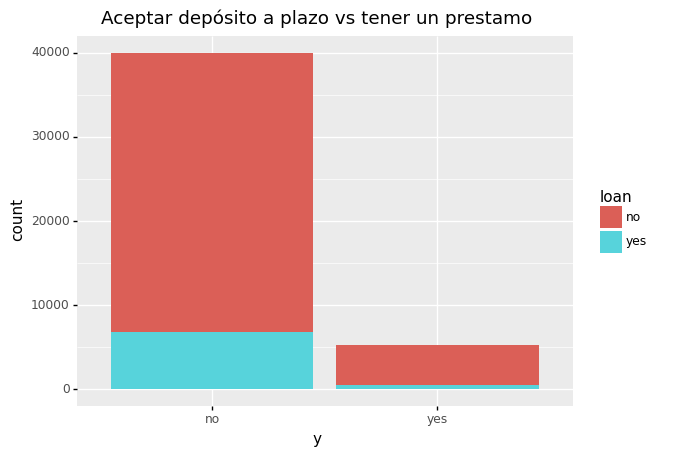

<ggplot: (327314210)>

In [116]:
(
    ggplot(train_full.assign(count = 1), aes( x = 'y', y = 'count', fill = 'loan')) + 
    geom_col() + 
    labs(title = "Aceptar depósito a plazo vs tener un prestamo")
)

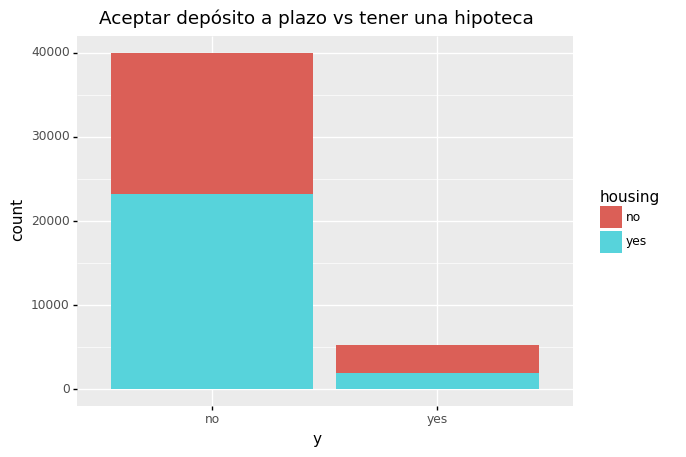

<ggplot: (327241903)>

In [117]:
(
    ggplot(train_full.assign(count = 1), aes( x = 'y', y = 'count', fill = 'housing')) + 
    geom_col() + 
    labs(title = "Aceptar depósito a plazo vs tener una hipoteca")
)

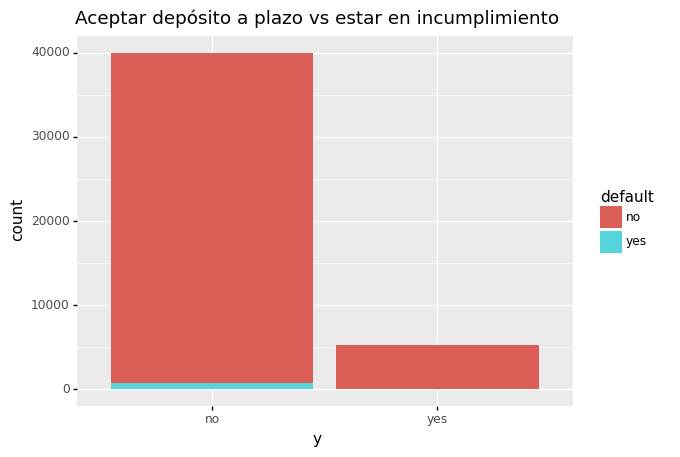

<ggplot: (327234338)>

In [118]:
(
    ggplot(train_full.assign(count = 1), aes( x = 'y', y = 'count', fill = 'default')) + 
    geom_col() + 
    labs(title = "Aceptar depósito a plazo vs estar en incumplimiento")
)

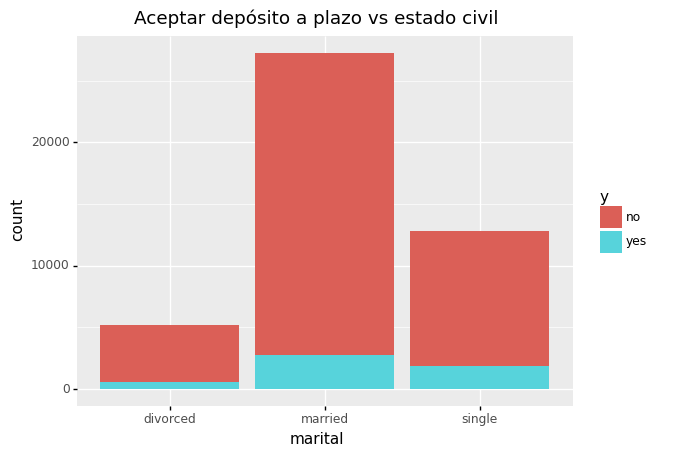

<ggplot: (324616174)>

In [126]:
(
    ggplot(train_full.assign(count = 1), aes( x = 'marital', y = 'count', fill = 'y')) + 
    geom_col() + 
    labs(title = "Aceptar depósito a plazo vs estado civil")
)

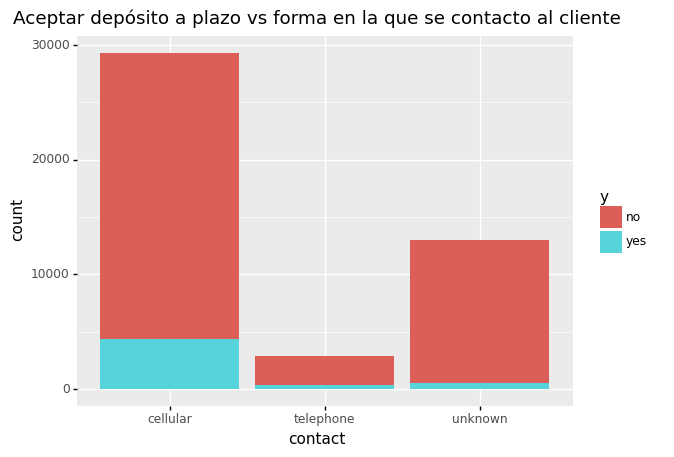

<ggplot: (337895671)>

In [127]:
(
    ggplot(train_full.assign(count = 1), aes( x = 'contact', y = 'count', fill = 'y')) + 
    geom_col() + 
    labs(title = "Aceptar depósito a plazo vs forma en la que se contacto al cliente")
)

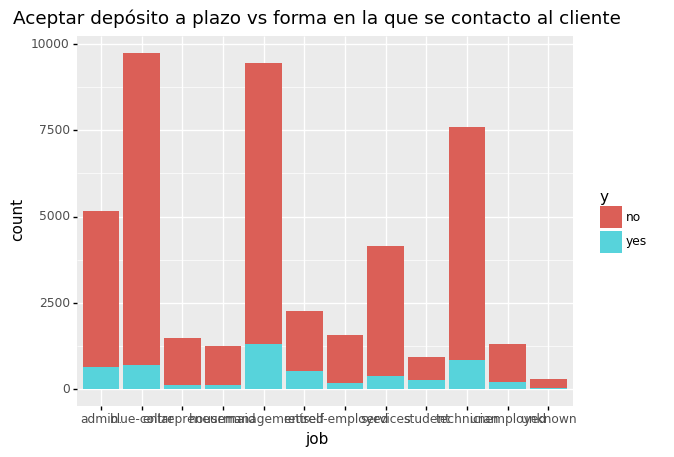

<ggplot: (324615211)>

In [125]:
(
    ggplot(train_full.assign(count = 1), aes( x = 'job', y = 'count', fill = 'y')) + 
    geom_col() + 
    labs(title = "Aceptar depósito a plazo vs forma en la que se contacto al cliente")
)

- Ingisghts:
    + Vemos que tenemos un problema de clasificación binaria con clases que no estan balanceadas. Esto no es malo, pero es una característica del problema de clasificación.
    + Tenemos características cuantitativas y cualitativas.
    + ¿Tenemos que usar todas? No necesariamente. A lo mejor tenemos que crear otras.

# 1. Construir conjuntos de entrenamiento, validación y prueba

Veamos como podemos utilizar herramientas de visualización para diagnosticar el problema de clasificación y cómo tomar acciones para lidiar con un problema con desbalance en las clases. Asimismo, veamos como podemos construir mejores conjuntos de entrenamiento, validación y prueba.

## 1.1: Diagnosticar problemas de balance de clases

En el EDA vimos algunas gráficas para entender los datos. Puedes incluir en tus herramientas de visualización la gráfica de [Yellowbrick-Class Balance](https://www.scikit-yb.org/en/latest/api/target/class_balance.html). Esta gráfica es útil porque nos ahorra tiempo para producir una gráfica diagnóstico bien etiquetada y formateada.

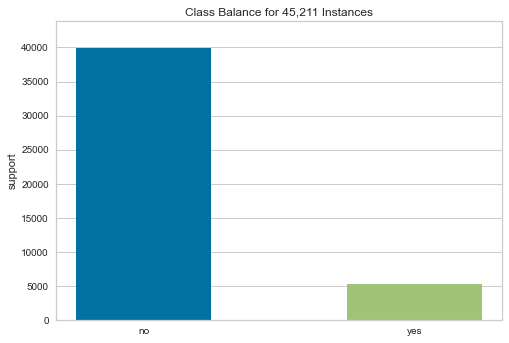

In [129]:
from yellowbrick.target import ClassBalance
class_visualizer = ClassBalance(
	labels=["no", "yes"]			# Indicamos las etiquetas de las clases. 
									# Ten cuidado con el orden de las etiquetas.
)
class_visualizer.fit(train_full.y)
class_visualizer.show(outpath="fig/profundiza/01_class_balance.png");

- Está gráfica nos permite ver que la magnitud del desbalance de clases es grande.
- Las implicaciones de este problema es que sea cual sea el algorítmo que usemos este tenderá a clasificar mejor la clase que tiene más observaciones que en este caso es aquellos clientes que no quieren el producto. La mayoría de los modelos asume que las clases están balanceadas.
- A la hora de modelar nuestros datos tendremos que adaptarlos para lidiar con este problema.

Para lidiar con el problema de desbalance existen varios métodos:

- En la función objetivo que optimizan los algorítmos, podemos ponderar con más peso las observaciones con la clase que tenemos pocas observaciones y ponderar con menos valor aquellas observaciones de la clase dominante.
- Podemos aplicar ténicas de remuestreo como upsampling o downsampling para construir nuevos conjuntos de datos balanceados entre clase.

En esta clase vamos a utilizar la reponderación, porque es fácil implementarla con los algorítmos y porque no queremos meternos en temas de remuestreo. Todos los algorítmos de sklearn tienen un atributo que se llama `class_weight` con el que podemos indicar con un número como vamos a reponderar las clases. En este caso es sencillo porque podemos indicar que queremos una ponderación balanceada como class_weight='balanced'.

Este detalle sútil ayudará a mejorar las predicciones.

## 1.2 Construir conjuntos de entrenamiento, validación y prueba para problemas desbalanceados.

- Ya que conocemos que tenemos un problema de desbalance hay que construir los conjunto de entrenamiento, validación y prueba.
- Utilizamos la siguiente estrategia: Train, validation y test split de 80%-10%-10%
- Es importante que cada uno de los tres conjuntos guarde la proporción de desbalance de todo el conjunto. Si utilizas la función de sklearn 'train_test_split', esta función se encargará de hacer esto automáticamente por ti.
- Dado que nos proporcionaron un conjunto de prueba, vamos a guardar esos datos para cuando le tengamos que dar las predicciones del mejor modelo al cliente. Para lo cual lo que vamos a hacer es un conjunto de validación para evaluar el desempeño de nuestros modelos y si quieres para comparar con tus compañeros del curso. 
- El conjunto de validación será del mismo tamaño que el conjunto de prueba (4,521 observaciones)

In [133]:
from sklearn.model_selection import train_test_split
train_set, validation_set = train_test_split(
    train_full,							# Pasamos el conjunto de entrenamiento 
    test_size = test_set.shape[0], 		# Indicamos la cantidad de observaciones que
    									# queremos en nuestro conjunto de validación.
    									# Observa que lo estamos haciendo en función
    									# del tamaño del conjunto de prueba, para 
    									# facilmente garantizar que saquemos otro
    									# 10% de los datos totales.
    stratify=train_full.y,				# Indica la variable por la que vamos a estratificar.
    random_state=42						# Proporcionamos una semilla para garantizar
    									# la reproducibilidad.
)

* Verifica que los conjuntos tengan las dimensiones correctas.

In [134]:
train_set.shape, validation_set.shape, test_set.shape

((40690, 17), (4521, 17), (4521, 17))

* Verifica que en los conjuntos la variable dependiente tenga la misma distribución.

In [135]:
train_set.y.value_counts(normalize=True)

no     0.883018
yes    0.116982
Name: y, dtype: float64

In [136]:
validation_set.y.value_counts(normalize=True)

no     0.88299
yes    0.11701
Name: y, dtype: float64

In [137]:
test_set.y.value_counts(normalize=True)

no     0.88476
yes    0.11524
Name: y, dtype: float64

## 1.3 Extracción de características

* Una vez que construimos nuestros conjuntos de datos, es momento de comenzar el preprocesamiento de los datos.
* Del EDA puedes concluir que los datos vienen razonablemente limpios, por lo que no se ocupó realizar grandes transformaciones.
* En esta sección comenzaremos a construir características, ya sea que agregemos las existentes, o creemos nuevas.
* No hay respuestas correcta, hay que iterar para llegar a la mejor combinación de características. 
* Aqui se muestra una propuesta de nuevas características.
* Asimismo, dado que hay que aplicar individualmente estas transformaciones a cada conjunto, creamos un conjunto de funciones que nos ayudan a simplificar esta tarea. Asegurate de leer la documentación de estas funciones para que veas que es lo que se propone.

In [138]:
def fun_preprocess_numeric_variables(df):
    '''Regresa un data frame con las variables numéricas preprocesadas.
    
    Codificar mes como una variable numéricas
    Seleccionar el resto de las varaibles numéricas.
    
    Parameters
    ----------
    df: DataFrame
        DataFrame con los datos del banco.
        
    Returns
    -------
    DataFrame
        DataFrame con los campos numéricos preprocesados . 
    '''
 
    month_enc = {
        'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 
        'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12
    }
    df_month = df.month.map(month_enc).to_frame()
    df_numeric = df[['day', 'duration', 'campaign', 'pdays', 'previous']]
    
    return pd.concat([df_month, df_numeric], axis = 1)

def fun_preprocess_categorical_variables(df):
    '''Regresar un data frame con las variables categóricas preprocesadas.

    Convierte en dummies las variables categóricas (loan, housing, marital contact, 
    unknown, other, education y job). 
    En algunos casos recodifica algunas categorías con replace.
    Para una variable categórica se elimina la primera opción con drop_first
    esto es para evitar problemas de multicolinealidad en algunos algorítmos.
    
    Parameters
    ----------
    df: DataFrame
        DataFrame con los datos del banco.
        
    Returns
    -------
    DataFrame
        DataFrame con los campos categóricos preprocesados.  
    '''
    
    df_loans = pd.get_dummies(df[['loan', 'housing', 'default']], drop_first = True)
    df_marital = pd.get_dummies(df[['marital']], drop_first = True)
    df_contact = pd.get_dummies(df[['contact']], drop_first = True)
    df_outcome = pd.get_dummies(
        df.poutcome.replace({'unknown':'other'}), 
        drop_first=True, 
        prefix = 'poutcome'
    )
    df_education = pd.get_dummies(
        df.education.replace(
            {'primary':'not undergraduate', 'secondary':'not undergraduate', 
             'unknown':'not undergraduate', 'tertiary':'undergraduate'}), 
        prefix = 'education', 
        drop_first=True
    )
    df_job = pd.get_dummies(
        df.job.replace(
            {'unknown':'other', 'unemployed':'other', 'housemaid':'other', 
             'entrepreneur':'other', 'student':'other', 'self-employed':'other'}), 
        prefix = 'job', 
        drop_first=True
    ) 
    return pd.concat([df_loans, df_marital, df_contact, df_outcome, df_education, df_job], axis = 1)

def fun_preprocesar_atributos(df):
    '''Regresa un DataFrame con los datos numéricos y categóricos preprocesados
    
    Parameters
    ----------
    df: DataFrame
        DataFrame con los datos del banco.
        
    Returns
    -------
    DataFrame
        DataFrame con los datos preprocesados
    '''
    df_numeric = fun_preprocess_numeric_variables(df) 
    df_categorical = fun_preprocess_categorical_variables(df)
    
    return pd.concat([df_numeric, df_categorical], axis = 1)

def fun_preprocesar_categoria(df):
    '''Regresa un numpy array con la variable dependiente
    
    Toma los datos del banco, extrae la variable dependiente,
    la convierte en una variable de dummy donde:
        1 = el cliente sí aceptó el depósito a plazo
        0 = el cliente no aceptó el depósito a plazo
        
    Asimismo, se convierten los datos a int64 y se formata el
    array para que tenga la siguiente dimensión (n, )
    
    
    Parameters
    ----------
    df: DataFrame
        DataFrame con los datos del banco.
        
    Returns
    -------
    ndarray
        Regresa un numpy array con dimensión (n, ) con la variable
        dependiente que toma valores de 1 y 0.
    '''
    
    return pd.get_dummies(df.y, drop_first=True).astype('int64').values.ravel()

* Estas líneas nos sirven para validar que las columnas de los tres conjuntos de datos después de aplicar el preprocesamiento están correctas.

In [139]:
assert fun_preprocesar_atributos(train_set).columns.tolist() == fun_preprocesar_atributos(test_set).columns.tolist()
assert fun_preprocesar_atributos(train_set).columns.tolist() == fun_preprocesar_atributos(validation_set).columns.tolist()

* Compara cómo cambian las dimensiones de nuestros conjuntos de datos después del preprocesamiento. ¿Por qué tenemos más columnas?

In [140]:
# Antes
train_set.shape, validation_set.shape, test_set.shape

((40690, 17), (4521, 17), (4521, 17))

In [141]:
# Después
fun_preprocesar_atributos(train_set).shape, fun_preprocesar_atributos(validation_set).shape, fun_preprocesar_atributos(test_set).shape

((40690, 22), (4521, 22), (4521, 22))

* Para entrenar nuestros modelos tienes que separar en una matriz o DataFrame a los predictores y en un arreglo o vector a la variable dependiente.

In [23]:
X_train = fun_preprocesar_atributos(train_set)
y_train = fun_preprocesar_categoria(train_set)

X_val = fun_preprocesar_atributos(validation_set)
y_val = fun_preprocesar_categoria(validation_set)

X_test = fun_preprocesar_atributos(test_set)
y_test = fun_preprocesar_categoria(test_set)

* Observa cómo cambian las dimensiones, en particular las de la variable dependiente.

In [24]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((40690, 22), (4521, 22), (4521, 22), (40690,), (4521,), (4521,))

# 2. Construir un flujo de trabajo para optimizar problemas de regresión 

## 2.1 Visualización de árboles

### Modelo base

- El primer paso en la práctica del análisis predictivo es construir lo más inmetiado posible un pipeline que nos permita comenzar a ajustar un modelo e irlo mejorando iterativamente. Recuerda que el análisis predictivo es un proceso. Rara vez el ajuste de un modelo sale a la primera vez.
- Asimismo, necesitamos establecer un punto de partida para ir mejorando el modelo. Para esto podriamos suponer que a cada llamada le asignamos una probabilidad de 0.5 de que la persona acepte el producto o lo rechace. En otras palabras lanzamos una moneda.

In [25]:
from sklearn.tree import DecisionTreeClassifier
# Especificamos un modelo de árbol de decisión
clf_dt = DecisionTreeClassifier(
    max_depth = 2, 
    class_weight = 'balanced', 	# Indicamos que se deben reponderar las clases.
    random_state=seed			# Indicamos una semilla para reproducibilidad.
)
# Ajustamos el modelo y predecimos
clf_dt.fit(X_train, y_train)
y_pred = clf_dt.predict(X_val)

Podemos utilizar una herramienta de visualización de árboles para comprender cómo el modelo hace la clasificación.

/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/diplomado/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


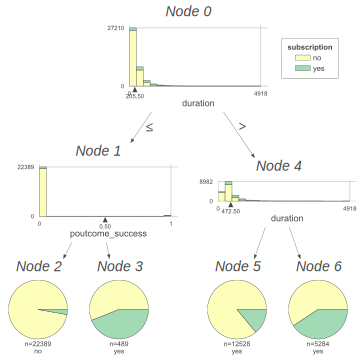

In [26]:
import dtreeviz
# Construimos una visualización
viz = dtreeviz.trees.dtreeviz(
    clf_dt, 						# Especificamos el modelo (debe ser un estimador) 
    X_train, y_train, 				# Especificamos los datos de entrenamiento
    feature_names=X_train.columns, 	# Escpeficiamos el nombre las variables
    target_name = 'subscription', 	# Indicamos como se llama la variable de clasificación
    class_names={0:'no', 1:'yes'}, 	# Indicamos el nombre de las clases
    show_node_labels=True, 			# Indicamos que queremos el nombre de los nodos
)
viz.save("fig/profundiza/02_decision_tree.svg")
viz

Es posible gráficar el árbol y tomar un cliente para entender donde es clasificado.

In [27]:
# Seleccionamos un cliente, el que sea
datos_cliente_ejemplo = X_train.iloc[28079]
datos_cliente_ejemplo

month                       5
day                        26
duration                   80
campaign                    1
pdays                      -1
previous                    0
loan_yes                    0
housing_yes                 0
default_yes                 0
marital_married             1
marital_single              0
contact_telephone           0
contact_unknown             1
poutcome_other              1
poutcome_success            0
education_undergraduate     0
job_blue-collar             0
job_management              0
job_other                   0
job_retired                 0
job_services                0
job_technician              0
Name: 5700, dtype: int64

/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/diplomado/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


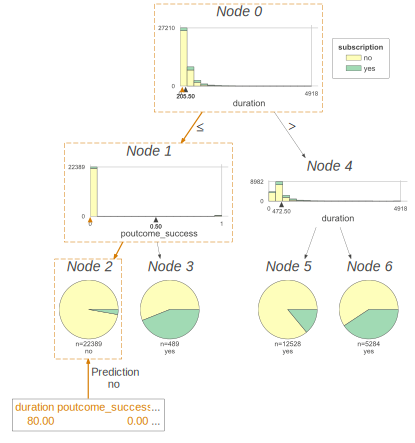

In [28]:
# Construimos el árbol para explciar el camino
viz = dtreeviz.trees.dtreeviz(
    clf_dt, 						
    X_train, y_train, 				
    feature_names=X_train.columns, 	
    target_name = 'subscription', 	
    class_names={0:'no', 1:'yes'}, 	
    show_node_labels=True, 			
    X = datos_cliente_ejemplo, 		# Damos los datos para un solo cliente
)
viz.save("fig/profundiza/03_decision_tree_client_prediction.svg")
viz

Igualmente puede obtenerse esta explicación utilizando texto. Esto puede ser útil en modelos más grandes.

In [29]:
from dtreeviz.trees import explain_prediction_path
print(
    explain_prediction_path(
        clf_dt,								# Especificamos el modelo (debe ser un estimador ajustado) 
        datos_cliente_ejemplo, 				# Proporcionamos los datos del cliente ejemplo
        feature_names=X_train.columns, 		# Proporcionamos el nombre de las variables
        explanation_type="plain_english"	# Indicamos que la explicación la queremos en palabras.
    )
)											# Para que los resultados se vean bien hay que encerarrlos 
											# en la función print

duration < 205.5
poutcome_success < 0.5



**APRENDE:**

- Prueba con diferentes hiperparámetros y valores y compara las gráficas.

In [30]:
# Especificamos un modelo de árbol de decisión

#clf_dt = DecisionTreeClassifier(
#    'hiperparámetro' = 'valor', # Prueba con otros hiperparámetros y valores
#    class_weight = 'balanced', 
#    random_state=seed
#)
#
# # Ajustamos el modelo y predecimos
# clf_dt.fit(X_train, y_train)
# y_pred = clf_dt.predict(X_val)
## Construimos una visualización
#dtreeviz.trees.dtreeviz(
#    clf_dt, 
#    X_train, y_train, 
#    feature_names=X_train.columns, 
#    target_name = 'subscription', 
#    class_names={0:'no', 1:'yes'}, 
#    show_node_labels=True
#)

- De esta visualización podemos concluir rapidamente que un árbole de decisión con una profundidad pequeña de árboles es muy rígida para poder encontrar en el ruido de los datos aquellos clientes que sí aceptaron.

- Veamos como le fue a este modelo, para lo cual utilizaremos dos herramientas de visualización de la librerías Yellowbrick, que sintetizan varios de los conceptos para evaluar un modelo de clasificación. Vamos a utilizar la matriz de confusión y el classification report.

## 2.2 Regularización árboles

### Curvas de validación

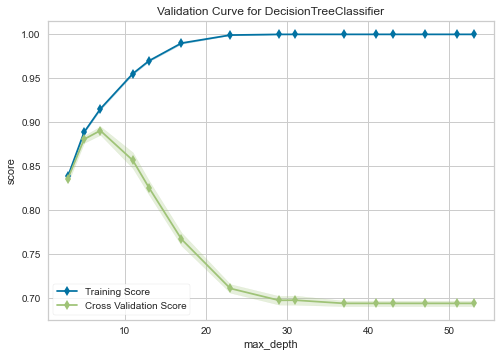

In [31]:
from yellowbrick.model_selection import ValidationCurve

# Especificamos un modelo de árbol de decisión
clf_dt = DecisionTreeClassifier(
    max_depth = 4, 
    class_weight = 'balanced', 	# Indicamos que se deben reponderar las clases.
    random_state=seed			# Indicamos una semilla para reproducibilidad.
)

# Especificamos la curva de validación
viz = ValidationCurve(
    clf_dt, 							# Especificar el modelo (debe ser un estiamdor)
    param_name="max_depth",				# Especificar un solo hiperparámetro a evaluar
    param_range=[3, 5, 7, 11, 13, 17, 	# Dara una lista o numpy.array con los valores probar
    			23, 29, 31, 37, 41, 
    			43, 47, 51, 53], 
    cv=5, 								# Indicar el valor k, para construir la validación cruzada
    scoring="roc_auc",					# Indicar la métrica de evaluación para el modelo.
    n_jobs=-1							# Indicar cuántos CPUs utilizar para paralelizar el trabajo.
    									# n_jobs=-1, signfica utilizar todos los CPUs disponibles.
)
# Ajustamos el modelo y la visualización
viz.fit(X_train, y_train)
# Imprimimos en la pantalla la visualización.
viz.show(outpath="fig/profundiza/04_curva_validacion_max_depth.png");

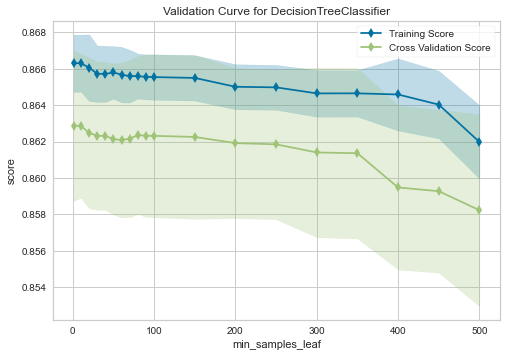

In [32]:
viz = ValidationCurve(
    clf_dt, 							
    param_name="min_samples_leaf",		# Probamos con un nuevo hiperparámetro 
    param_range=[1, 10, 20, 30, 40,		# Especificamos una lista con los nuevos
    			50, 60, 70, 80, 90,		# valores. 
    			100, 150, 200, 250, 
    			300, 350, 400, 450, 
    			500], 
    cv=5, 
    scoring="roc_auc",
    n_jobs=-1
)
# Ajustamos el modelo y la visualización
viz.fit(X_train, y_train)
# Imprimimos en la pantalla la visualización.
viz.show(outpath="fig/profundiza/05_curva_validacion_min_samples_leaf.png");

**APRENDE:**
    
Reutiliza el código y construye una nueva curva de apredizaje para un hiperparámetro diferente. 

- Por ejemplo para `min_samples_split`


In [ ]:
# Especificamos un modelo de árbol de decisión
#clf_dt = DecisionTreeClassifier(
#    max_depth = 7, 
#    ________________ = _______________,
#    class_weight = 'balanced', 	# Indicamos que se deben reponderar las clases.
#    random_state=seed			# Indicamos una semilla para reproducibilidad.
#)
#
## Especificamos la curva de validación
#viz = ValidationCurve(
#    clf_dt, 							# Especificar el modelo (debe ser un estiamdor)
#    param_name="min_samples_split",				# Especificar un solo hiperparámetro a evaluar
#    param_range= __________________, 
#    cv=5, 								# Indicar el valor k, para construir la validación cruzada
#    scoring="roc_auc",					# Indicar la métrica de evaluación para el modelo.
#    n_jobs=-1							# Indicar cuántos CPUs utilizar para paralelizar el trabajo.
#    									# n_jobs=-1, signfica utilizar todos los CPUs disponibles.
#)
## Ajustamos el modelo y la visualización
#viz.fit(X_train, y_train)
## Imprimimos en la pantalla la visualización.
#viz.show();

## 2.3 Exploración de hiperparámetros y selección del mejor modelo. 

- La pregunta es cómo seleccionamos el parámetro óptimo para la profundidad de un árbol `max_depth`.
- Para seleccionar hiper parámetros debemos hacer varias iteraciones y evaluar en el conjunto de prueba.

### Búsqueda de hiperparámetros

In [33]:
from sklearn.model_selection import GridSearchCV
# Especificamos un modelo de árbol de decisión
clf_dt = DecisionTreeClassifier(
    class_weight = 'balanced', 	# Indicamos que se deben reponderar las clases.
    random_state=seed			# Indicamos una semilla para reproducibilidad.
)

# Especificar diccionario de parámteros y valores a explorar
params = {
    'max_depth':[5, 10, 50, 100, 150, 200],
    'min_samples_split':[2, 4, 6, 8],
    'min_samples_leaf':[1, 2, 4, 5]
}
# Especificar opciones del Grid Search 
grid_search = GridSearchCV(
    clf_dt, 				# Indicar el modelo (debe ser un estimador).
    scoring = 'roc_auc', 	# Indicar la métrica para evaluar el desempeño del
    						# modelo en validación cruzada.
    param_grid=params, 		# Indicar el diccionario de parámetros y valores
    cv = 10, 				# Indicar los k cortes de validación cruzada.
    return_train_score=True,# Agregar el error de entrenamiento
    n_jobs = -1				# Indicar cuántos CPUs utilizar para paralelizar el 
    						# trabajo.

)
# Entrenar los modelos
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=20210610),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 50, 100, 150, 200],
                         'min_samples_leaf': [1, 2, 4, 5],
                         'min_samples_split': [2, 4, 6, 8]},
             return_train_score=True, scoring='roc_auc')

Podemos recuperar los resultados de la búsqueda de parámetros, utilizando el atributo de `cv_results_` y la función auxiliar de `fun_plot_grid_search_results` para visualizarlos. 

In [34]:
def fun_plot_grid_search_results(df):   
    '''Regresa un DataFrame con los resultados de la exploración de hiperparámetros.

    Esta función muestra una tabla estilizada con los resultados de la exploración de
    hiper parámetros utilizando validación cruzada.
    
    En la tabla aparecen del lado izquierdo la combinación de hiperparámetros, el error
    de entrenamiento y el error de validación cruzada y el ranking del mejor modelo
    a partir del error de validación.
    
    El mapa de color va de azul (modelos con menor error) a rojo (modelos con mayor error).
    Se calcula para el error de entrenamiento y validación de manera separada.
    
    Los resultados están ordenados de mejor a peor modelo, en función del error de validación.
    
    Parameters
    ----------
    dict: Diccionario con los resultados de la búsqueda de hiperparámetros GridSearchCV.cv_results_ 
        
    Returns
    -------
    pandas.io.formats.style.Styler
        Regresa una tabla estilizada con los resultados de la búsqueda de hiperparámetros.
    '''
    # Elegir paleta divergente de colores
    cm = sns.diverging_palette(5, 250, as_cmap=True)
    
    return (
        pd.concat([
            # Limpiar la columna de parámetros
            df['params'].apply(pd.Series), 
            # Extraer solamente el error de prueba 
            df[['mean_train_score', 'mean_test_score', 'rank_test_score']]],
            axis = 1
        )
        # Ordenar los modelos de mejor a peor
        .sort_values(by = 'rank_test_score')
        # Pintar el fondo de la celda a partir del error de validación
        .style.background_gradient(cmap=cm, subset = ['mean_train_score', 'mean_test_score'])
    )

In [35]:
# Recupearar los resultados de la validación cruzada
df_best_params = pd.DataFrame(grid_search.cv_results_)
tabla_resultados = fun_plot_grid_search_results(df_best_params)
tabla_resultados

,max_depth,min_samples_leaf,min_samples_split,mean_train_score,mean_test_score,rank_test_score
28,10,5,2,0.944066,0.886499,1
29,10,5,4,0.944066,0.886499,1
30,10,5,6,0.944066,0.886499,1
31,10,5,8,0.944066,0.886499,1
12,5,5,2,0.889661,0.884041,5
15,5,5,8,0.889661,0.884041,5
14,5,5,6,0.889661,0.884041,5
13,5,5,4,0.889661,0.884041,5
25,10,4,4,0.944664,0.883122,9
26,10,4,6,0.944664,0.883122,9


### Selección del mejor modelo

In [36]:
def fun_resumen_grid_search(grid_search):
    '''Imprime un resumen del grid search.
    
    Imprime el número de modelos que se entrenaron y 
    devuelve los hiperparámetros del mejor modelo.
    
    Parameters
    ----------
    grid_search (GridSearchCV): Fitted GridSearch con los resultados.
    '''
    best_params = grid_search.best_params_
    print("\nSe evaluaron {} modelos utilizando el grid search.".format(pd.DataFrame(grid_search.cv_results_).shape[0]))
    print("\nLos hiperparámetros del mejor modelo son: " + str(best_params) + "\n")

In [37]:
# Recuepar los resultados de la validación cruzada.
fun_resumen_grid_search(grid_search)


Se evaluaron 96 modelos utilizando el grid search.

Los hiperparámetros del mejor modelo son: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}



In [38]:
# Recuperar el estimador del mejor modelo.
best_model = grid_search.best_estimator_

### Predicciones

In [82]:
# Utilizar el mejor modelo para predecir la clase 
y_pred = best_model.predict(X_val)
# Mostrar las clases de los primeros 20 clientes
y_pred[:20]

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1])

In [83]:
# Utilizar el mejor modelo para predecir la probabilidad.
y_pred_proba = best_model.predict_proba(X_val)[:,1]
# Mostrar las probabilidades de los primeros 20 clientes
y_pred_proba[:20]

array([0.        , 0.00669857, 0.64446097, 0.38266793, 0.03042329,
       0.8892257 , 0.04950311, 0.89530824, 0.00669857, 0.        ,
       0.91116503, 0.        , 0.        , 0.25391109, 0.        ,
       0.96647827, 0.        , 0.67607028, 0.        , 0.83753543])

# 3. Evaluación de ajuste 

## 3.1 Graficar la calidad del ajuste

### Errores de clasificación y matriz de confusión.

Visualizamos los errores de predicción de clases utilizando una gráfica de distribución de clases.

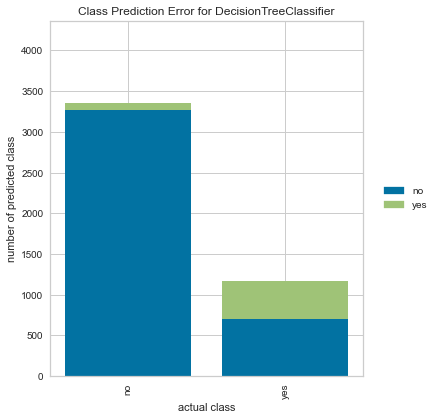

In [41]:
from yellowbrick.classifier import ClassPredictionError
# Creamos la figura
fig, ax = plt.subplots(figsize = (7,6))
cpe_viz = ClassPredictionError(
    best_model,					# Pasar el estimador del mejor modelo que 
    							# se obtiene de la validación cruzada.  
    classes = ['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
cpe_viz.fit(X_train, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
cpe_viz.score(X_val, y_val)
# Dibjuamos la visualización.
cpe_viz.show(outpath="fig/profundiza/07_error_clasificacion.png");

Visualizamos la misma información pero ahora en forma de una matriz de confusión.

Documentación: [Yellowbrick-Confusion Matrix](https://www.scikit-yb.org/en/latest/api/classifier/confusion_matrix.html)

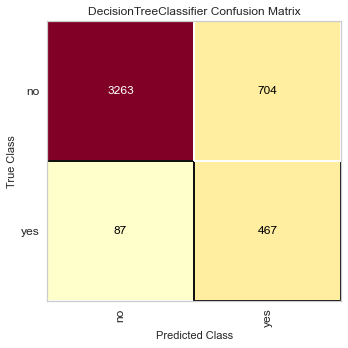

In [42]:
from yellowbrick.classifier import ConfusionMatrix
fig, ax = plt.subplots(figsize = (5,5))
# Creamos la matrix de confusión
cm = ConfusionMatrix(
    best_model, 				# Pasar el estimador del mejor modelo que 
    							# se obtiene de la validación cruzada. 
    classes=['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
cm.fit(X_train, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
cm.score(X_val, y_val)
# Dibjuamos la visualización.
cm.show(outpath="fig/profundiza/08_matriz_confusion.png");

In [43]:
# Matriz de confusión implementación de Sklearn
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[3263,  704],
       [  87,  467]])

- Idealmente lo que buscamos es que todos los valores de la matriz de confusión se encuentren en la diagonal de Verdaderos Positivos y Verdaderos Negativos.
- Este modelo nos muestra que todos los clientes que sí aceptaron el producto, el modelo los clasificó como que no aceptaron el producto. Es decir nuestro modelo no clasificó bien.

## 3.2 Selección del punto de corte para problemas de clasificación binaria 

Visualizamos cómo cambia la precision y el recall para distintos puntos de corte con nuesto modelo.

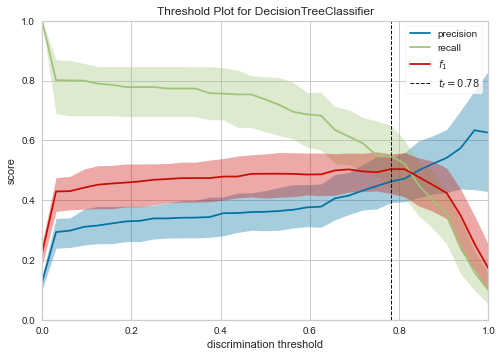

In [44]:
from yellowbrick.classifier.threshold import DiscriminationThreshold
# Especificamos la gráfica
visualizer = DiscriminationThreshold(
	best_model,							# Pasar el estimador del mejor modelo que 
    									# se obtiene de la validación cruzada. 
	exclude = ["queue_rate"]			# Excluimos de la gráfica algunas métricas
)
# Ajustamos la visualización a los datos de entrenamiento
visualizer.fit(X_val, y_val)
# Dibjuamos la visualización.
visualizer.show(outpath="fig/profundiza/09_discrimination_threshold.png");  

In [45]:
# Clasificar con un punto de corte más alto que 0.5
def fun_predict_with_threshold(model, threshold = 0.5):
    '''Predice la clase del cliente utilizando un threshold
    
    Permite predecir la clase de un cliente utilizando otros 
    puntos de corte (threshold) que sean diferentes a 0.5.
    
    Parameters
    ----------
    model: Fitted estimator
    threshold (float): Punto de corte entre 0 y 1.
        
    Returns
    -------
    ndarray:
        Regresa un numpy array con el valor de la clase 0 ó 1
    '''
    return np.where( model.predict_proba(X_val)[:,1] < threshold, 0, 1 )

In [46]:
# Calcular clases con un punto de corte en 0.75
y_pred_075 = fun_predict_with_threshold(best_model, threshold = 0.75)
# Mostrar primeros 20 clientes
y_pred_075[:20]

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1])

### Reporte de clasificación, recall, precision y f1-score

Calculamos las métricas de evaluación utilizando los métodos de sklearn.

In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score
def fun_imprimir_metricas_de_evaluacion(y_true, y_pred):
    '''Imprimer los resultados de precision, recall y f1 score
    
    Implementa las métricas de precision, recall y f1 score de
    sklearn para la categoría 1= sí acepta el depósito a plazo.
    
    Parameters
    ----------
    y_true (ndarray): Array con las clases actuales 
    y_pred (ndarray): Array con las clases predichas 
    '''
    print("precision_score: {}".format(np.round(precision_score(y_true, y_pred), 3)))
    print("recall_score: {}".format(np.round(recall_score(y_true, y_pred), 3)))
    print("f1_score: {}".format(np.round(f1_score(y_true, y_pred), 3)))

In [48]:
fun_imprimir_metricas_de_evaluacion(y_val, y_pred)

precision_score: 0.399
recall_score: 0.843
f1_score: 0.541


Ahora probamos lo mismo utilizando las visualizaciones de Yellowbrick.

Documentación: [Yellowbrick-Classification Report](https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html)

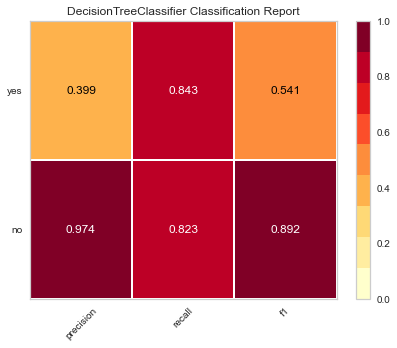

In [49]:
from yellowbrick.classifier import ClassificationReport
fig, ax = plt.subplots(figsize = (6,5))
visualizer = ClassificationReport(
    best_model,					# Pasar el estimador del mejor modelo que 
    							# se obtiene de la validación cruzada. 
    classes=['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
visualizer.fit(X_train, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
visualizer.score(X_val, y_val)
# Dibjuamos la visualización.
visualizer.show();

- En esta visualización vemos medidas de calidad de la clasificación del modelo. Vemos la precisión y el recall y el F1-score. Para cada una de las categorías.
- Idealmente buscamos que estas medidas sean altas. Esta visualización en forma de matriz y mapa de calor es útil porque un buen modelo sería aquel en el que ambas categorías sean igualmente rojas. 
- Dado que el primer modelo que hicimos no clasificó a nadie en la categoría de Sí acepto el producto, entonces las medidas de precisión, recall y F1 score tienen valor cero. 

### Curva de precision y recall

Visualizamos el trade-off de la precision y recall.

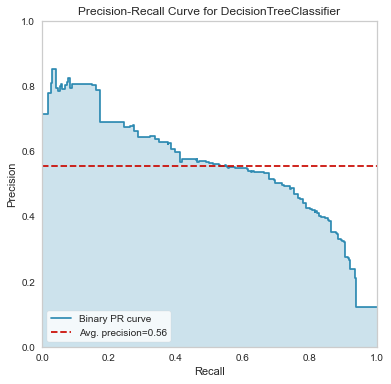

In [50]:
from yellowbrick.classifier import PrecisionRecallCurve
# Especificamos la curva de precision y recall
fig, ax = plt.subplots(figsize = (6,6))
viz = PrecisionRecallCurve(best_model) 			# Pasamos el estimado del mejor modelo
												# que obtuvimos con validación cruzada.
# Ajustamos la visualización con los 
# datos de entrenamiento
viz.fit(X_train, y_train)
# Evaluamos con los datos de prueba
viz.score(X_val, y_val)
# Dibujamos la visualización
viz.show();

### Curva ROC y AUC score

Creamos la curva ROC AUC para visualizar el trade off de recall y specificity.

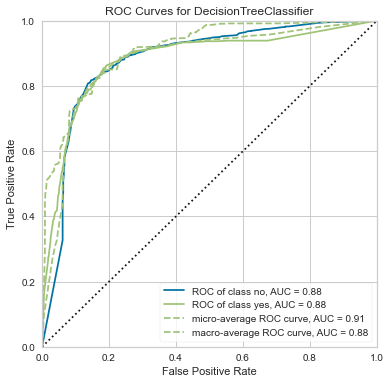

In [51]:
from yellowbrick.classifier import ROCAUC
# Especificamos la curva ROC AUC
fig, ax = plt.subplots(figsize = (6,6))
roc_curves_visualizer = ROCAUC(
    best_model,					# Pasar el estimador del mejor modelo que 
    							# se obtiene de la validación cruzada.  
    classes=['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
roc_curves_visualizer.fit(X_train, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
roc_curves_visualizer.score(X_val, y_val) 
# Dibjuamos la visualización.
roc_curves_visualizer.show();

In [52]:
from sklearn.metrics import roc_auc_score
# Implementación de las métricas con sklearn
print("roc_auc_score: {}".format(np.round(roc_auc_score(y_val, y_pred_proba), 3)))

roc_auc_score: 0.88


## 3.3 Visualizar la importancia de características (Feature Importances) 

Exploramos cuáles son las variables que tienen una mayor importancia.

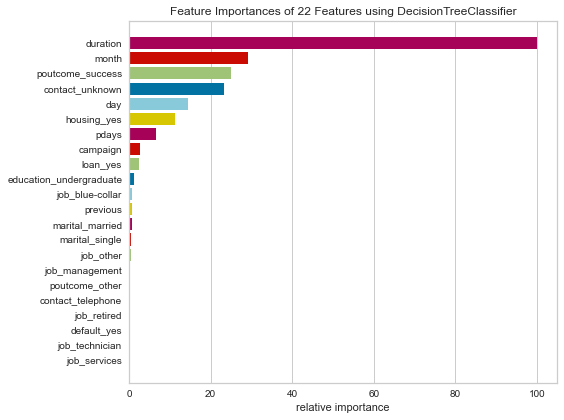

In [53]:
from yellowbrick.model_selection import FeatureImportances
# Especificamos la gráfica
fig, ax = plt.subplots(figsize = (8,6))
viz = FeatureImportances(best_model) 	# Pasar el estimador del mejor modelo que 
    									# se obtiene de la validación cruzada.
# Ajustamos la visualización a los datos de entrenamiento
viz.fit(X_train, y_train)
# Dibjuamos la visualización.
viz.show();

# 4. Evaluación de otros modelos

- Vemos que nuestro árbol de decisión para clasificar gente que aceptó el producto, lo mejor que puede hacer es X.
- ¿Habrá otro modelo que se desempeñe mejor?
- Intentemos con un modelo de árboles más complejo, un Bosque Aleatorio, y aprovechemos el código que ha hicimos para validar hiperparámetros. 
- Lo único que tenemos que hacer es adaptar el diccionario de hiperparámetros a este nuevo modelo.
- Para evaluar nuestros modelos una buena práctica sería convertir todas las visualizaciones que hicimos arriaba en funciones para no escribir tanto código.

In [80]:
from yellowbrick.classifier.threshold import DiscriminationThreshold
from yellowbrick.classifier import (
    ConfusionMatrix, ClassPredictionError, ClassificationReport,
    PrecisionRecallCurve, ROCAUC, ClassPredictionError
)
from yellowbrick.model_selection import FeatureImportances

def fun_graficar_matriz_confusion(model, X_val_test, y_val_test):
    '''Graficar matriz de confusión
    
    Parameters
    ----------
    model (Estimator): Fitted estimator
    X_test (DataFrame): Predictores del conjunto de validación o prueba.
    y_test (ndarray): Clases del conjunto de validación o prueba.
    ''' 
    fig, ax = plt.subplots(figsize = (5,5))
    cm = ConfusionMatrix(
        model,
        classes=['no', 'yes']
    )
    cm.fit(X_train, y_train)
    cm.score(X_val_test, y_val_test)
    cm.show();
    
def fun_graficar_reporte_clasificacion(model, X_val_test, y_val_test):
    '''Graficar reporte de clasificación
    
    Parameters
    ----------
    model (Estimator): Fitted estimator
    X_test (DataFrame): Predictores del conjunto de validación o prueba.
    y_test (ndarray): Clases del conjunto de validación o prueba.
    '''   
    fig, ax = plt.subplots(figsize = (6,5))
    visualizer = ClassificationReport(
        model,
        classes=['no', 'yes']
    )
    visualizer.fit(X_train, y_train)
    visualizer.score(X_val_test, y_val_test)
    visualizer.show();  
    
def fun_graficar_curva_precision_recall(model, X_val_test, y_val_test):
    '''Graficar curva de precision y recall
    
    Parameters
    ----------
    model (Estimator): Fitted estimator
    X_test (DataFrame): Predictores del conjunto de validación o prueba.
    y_test (ndarray): Clases del conjunto de validación o prueba.
    '''
    fig, ax = plt.subplots(figsize = (6,6))
    viz = PrecisionRecallCurve(model)
    viz.fit(X_train, y_train)
    viz.score(X_val_test, y_val_test)
    viz.show();
    
def fun_graficar_curva_roc(model, X_val_test, y_val_test):
    '''Graficar curva ROC
    
    Parameters
    ----------
    model (Estimator): Fitted estimator
    X_test (DataFrame): Predictores del conjunto de validación o prueba.
    y_test (ndarray): Clases del conjunto de validación o prueba.
    '''
    fig, ax = plt.subplots(figsize = (6,6))
    roc_curves_visualizer = ROCAUC(
        model,
        classes=['no', 'yes']
    )
    roc_curves_visualizer.fit(X_train, y_train)
    roc_curves_visualizer.score(X_val, y_val) 
    roc_curves_visualizer.show();
    
def fun_imprimir_roc_auc_score(model, X_val_test, y_val_test):
    '''Imprime el ROC AUC score
    
    Parameters
    ----------
    model (Estimator): Fitted estimator de un DecisionTree, Random Forest o xgboost.
    X_val_test (DataFrame): Clases actuales
    y_val_test (ndarray): Probabildades de clase
    '''
    print(
        "roc_auc_score: {}".format(
            np.round(roc_auc_score(y_val_test, model.predict_proba(X_val_test)[:,1]), 3)
        )
    )
    
def fun_graficar_error_clasificacion(model, X_val_test, y_val_test):
    '''Graficar error de clasificación
    
    Parameters
    ----------
    model (Estimator): Fitted estimator
    X_test (DataFrame): Predictores del conjunto de validación o prueba.
    y_test (ndarray): Clases del conjunto de validación o prueba.
    '''
    fig, ax = plt.subplots(figsize = (7,6))
    cpe_viz = ClassPredictionError(model, classes = ['no', 'yes'])
    cpe_viz.fit(X_train, y_train)
    cpe_viz.score(X_val_test, y_val_test)
    cpe_viz.show();

def fun_graficar_importancias(model):
    '''Graficar importancia de características
    
    Parameters
    ----------
    model (Estimator): Fitted estimator de un DecisionTree, Random Forest o xgboost.
    '''
    fig, ax = plt.subplots(figsize = (8,6))
    viz = FeatureImportances(model)
    viz.fit(X_train, y_train)
    viz.show();
    
def fun_graficar_discrimination_threshold(model, X_val_test, y_val_test):
    '''Graficar relación de precision y recall con distintos puntos de corte
    
    Parameters
    ----------
    model (Estimator): Fitted estimator de un DecisionTree, Random Forest o xgboost.
    X_val_test (DataFrame): Clases actuales
    y_val_test (ndarray): Probabildades de clase
    '''
    fig, ax = plt.subplots(figsize = (8,6))
    visualizer = DiscriminationThreshold(
        model,
        exclude = ["queue_rate"]
    )
    visualizer.fit(X_val_test, y_val_test)
    visualizer.show();     

## 4.1 Random Forest

In [55]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Especificar bosque aleatorio
clf_rf = RandomForestClassifier(
    random_state = seed, 
    class_weight = 'balanced'
)
# Especificar la combinación de parámetros
# que queremos explroar.
#params = {
#    'n_estimators':[50, 100, 150, 200],
#    'max_depth':[5, 10, 25, 50],
#    'min_samples_split':[2, 4, 6, 8],
#    'min_samples_leaf':[1, 2, 4, 5]
#}

params = {
    'n_estimators':[200],
    'max_depth':[50],
    'min_samples_split':[8],
    'min_samples_leaf':[2]
}
# Especificar el GridSearch con validación cruzada
grid_search = GridSearchCV(
    clf_rf,					# Especificar el modelo (estimador)
    params, 				# Especificar los parámetros de la malla
    scoring = 'roc_auc', 	# Especificar la métrica de evaluación
    cv = 10, 				# Especificar los k-cortes de la validación cruzada
    return_train_score=True,# Agregar el error de entrenamiento
    n_jobs=-1				# Especificar el número de CPUs -1= todos los disponibles
)
# Entrenar los modelos
grid_search.fit(X_train, y_train)

CPU times: user 5.67 s, sys: 182 ms, total: 5.85 s
Wall time: 26.9 s


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=20210610),
             n_jobs=-1,
             param_grid={'max_depth': [50], 'min_samples_leaf': [2],
                         'min_samples_split': [8], 'n_estimators': [200]},
             return_train_score=True, scoring='roc_auc')

In [56]:
# Recupearar los resultados de la validación cruzada
df_best_params = pd.DataFrame(grid_search.cv_results_)
tabla_resultados = fun_plot_grid_search_results(df_best_params)
tabla_resultados

,max_depth,min_samples_leaf,min_samples_split,n_estimators,mean_train_score,mean_test_score,rank_test_score
0,50,2,8,200,0.990454,0.927733,1


In [57]:
# Recuepar los resultados de la validación cruzada.
fun_resumen_grid_search(grid_search)


Se evaluaron 1 modelos utilizando el grid search.

Los hiperparámetros del mejor modelo son: {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 200}



In [58]:
# Recuperar el estimador del mejor modelo.
best_model_rf = grid_search.best_estimator_

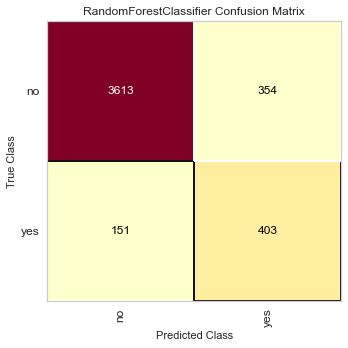

In [59]:
# Graficar matriz de confusión
fun_graficar_matriz_confusion(best_model_rf, X_val, y_val)

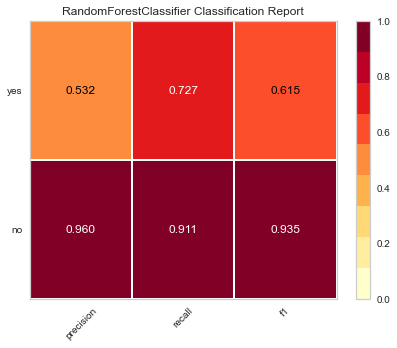

In [60]:
# Graficar reporte de clasificación
fun_graficar_reporte_clasificacion(best_model_rf, X_val, y_val)

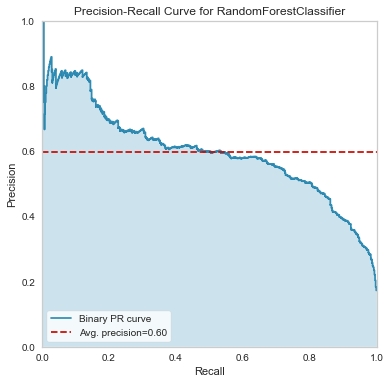

In [61]:
# Graficar curva de precision y recall
fun_graficar_curva_precision_recall(best_model_rf, X_val, y_val)   

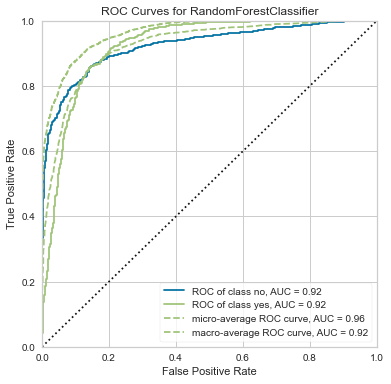

In [62]:
# Graficar curva ROC
fun_graficar_curva_roc(best_model_rf, X_val, y_val)

In [63]:
# Imprimir el ROC AUC score
fun_imprimir_roc_auc_score(best_model_rf, X_val, y_val)

roc_auc_score: 0.924


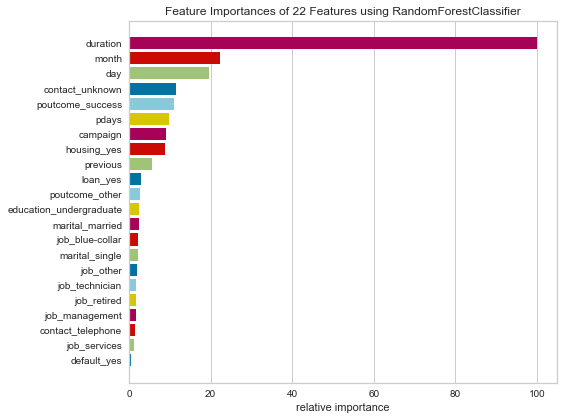

In [64]:
# Graficar importancia de características
fun_graficar_importancias(best_model_rf)

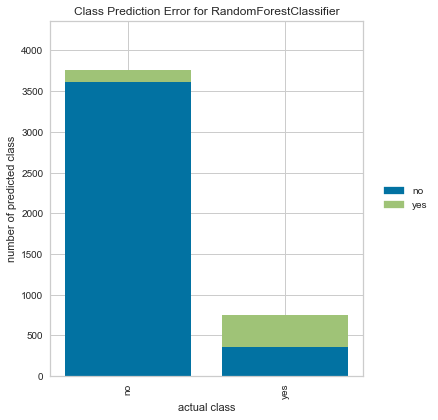

In [65]:
# Graficar error de clasificación
fun_graficar_error_clasificacion(best_model_rf, X_val, y_val)

## 4.2 Xgboost

In [66]:
import xgboost as xgb
# Especificamos el modelo 
# (Ojo, este algorítmo usa otros nombres para los parámetros)
clf_xgb = xgb.XGBClassifier(
    objective='binary:logistic',		# Para un problema de clasificación binaria
    eval_metric='auc',					# Métrica de evaluación
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    									# scale_pos_weight es el parámetro para 
    									# reponderar las categorías con desbalance.
    use_label_encoder=False,			# Hay que indicar esta opción
    random_state=seed					# Fijar semilla para reproducibilidad
)
# Especificar los parámetros a explorar
#params = {
#    'n_estimators':[50, 100, 150, 200],
#    'learning_rate':[.01, .001],
#    'max_depth':[5, 10, 25, 50],
#    'subsample':[0.25, 0.50, 0.75],
#    'colsample_bytree':[0.25, 0.50, 0.75],
#    'colsample_bylevel':[0.25, 0.50, 0.75],
#    'reg_lambda':[0.01, 10, 100, 150, 200]
#}

params = {
    'n_estimators':[150],
    'learning_rate':[.01],
    'max_depth':[10],
    'subsample':[0.75],
    'colsample_bytree':[0.75],
    'colsample_bylevel':[0.75],
    'reg_lambda':[0.01]
}

grid_search = RandomizedSearchCV(
	clf_xgb,					# Especificar el modelo (estimador) 
	params,						# Especificar los parámetros de la malla 
	scoring = 'roc_auc', 		# Especificar la métrica de evaluación
	cv = 10,					# Especificar los k-cortes de la validación cruzada 
	n_iter=100,					# Especificar número de modelos a explorar aleatoriamente 
    return_train_score=True,# Agregar el error de entrenamiento
	n_jobs=-1					# Especificar el número de CPUs para paralelizar el trabajo
    							# -1= todos los disponibles
)
# Entrenar los modelos
grid_search.fit(X_train, y_train)

/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/diplomado/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='auc', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=Non...
                                           scale_pos_weight=7.593453009503696,
                                           subsample=None, tree_method=None,
                         

In [67]:
# Recupearar los resultados de la validación cruzada
df_best_params = pd.DataFrame(grid_search.cv_results_)
tabla_resultados = fun_plot_grid_search_results(df_best_params)
tabla_resultados

,subsample,reg_lambda,n_estimators,max_depth,learning_rate,colsample_bytree,colsample_bylevel,mean_train_score,mean_test_score,rank_test_score
0,0.750000,0.010000,150.000000,10.000000,0.010000,0.750000,0.750000,0.972759,0.932342,1


In [68]:
# Recuepar los resultados de la validación cruzada.
fun_resumen_grid_search(grid_search)


Se evaluaron 1 modelos utilizando el grid search.

Los hiperparámetros del mejor modelo son: {'subsample': 0.75, 'reg_lambda': 0.01, 'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'colsample_bylevel': 0.75}



In [69]:
# Recuperar el estimador del mejor modelo.
best_model_xgb = grid_search.best_estimator_

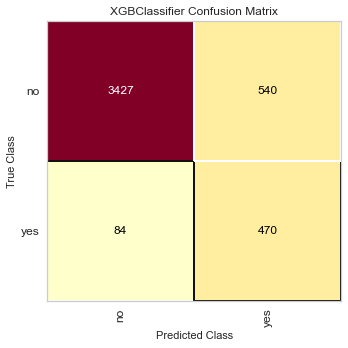

In [70]:
# Graficar matriz de confusión
fun_graficar_matriz_confusion(best_model_xgb, X_val, y_val)

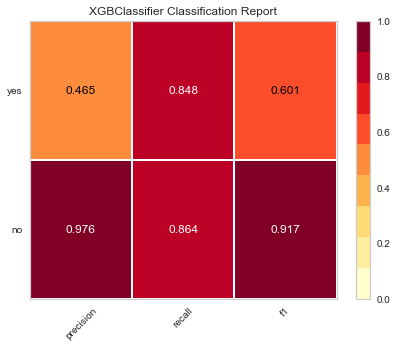

In [71]:
# Graficar reporte de clasificación
fun_graficar_reporte_clasificacion(best_model_xgb, X_val, y_val)

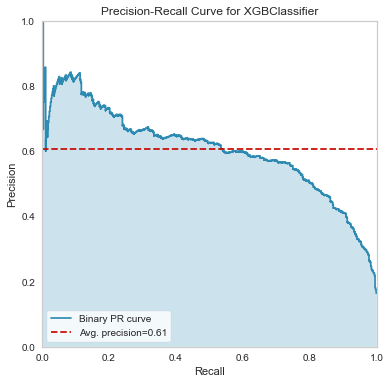

In [72]:
# Graficar curva de precision y recall
fun_graficar_curva_precision_recall(best_model_xgb, X_val, y_val)

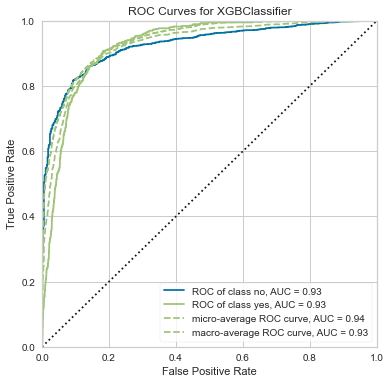

In [73]:
# Graficar curva ROC AUC
fun_graficar_curva_roc(best_model_xgb, X_val, y_val)

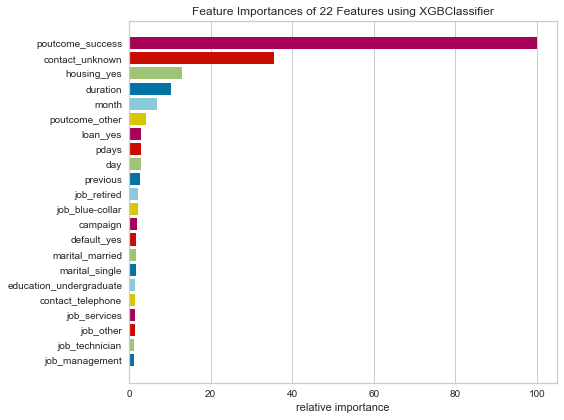

In [74]:
# Graficar importancia de características
fun_graficar_importancias(best_model_xgb)

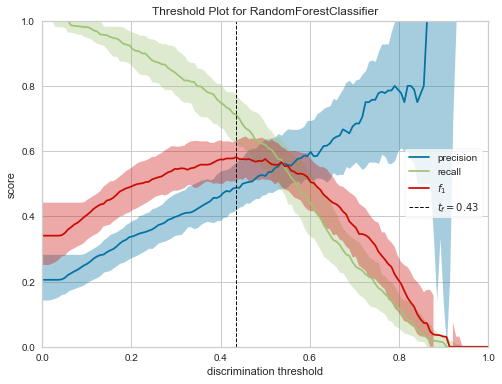

In [75]:
# Graficar curva de discriminación del punto de corte.
fun_graficar_discrimination_threshold(best_model_rf, X_val, y_val)

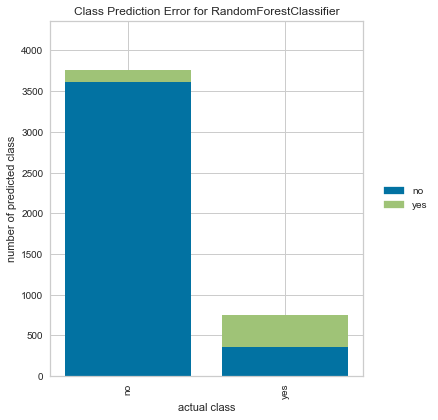

In [76]:
# Graficar error de clasificación
fun_graficar_error_clasificacion(best_model_rf, X_val, y_val)

## Selección del Mejor Modelo